In [71]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

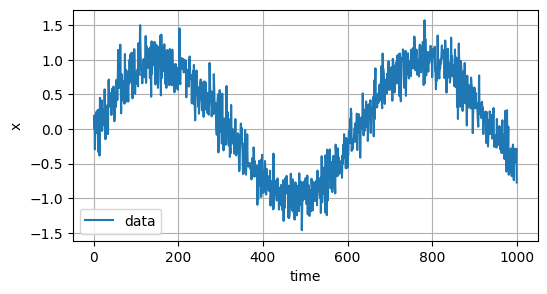

In [72]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T, ))

fig, ax = plt.subplots(figsize=(6, 3))
ax.grid(True)
ax.set_xlabel('time')
ax.set_ylabel('x')
ax.plot(time, x, label='data')
plt.legend()
plt.show()

In [73]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size = 16
n_train = 600
train_data = Data.TensorDataset(features[:n_train], labels[:n_train])
train_iter = Data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [74]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

def MLP():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    
    net.apply(init_weights)

    return net

loss = nn.MSELoss()

In [75]:
def train(net, train_iter, loss, n_epochs, lr):
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)

    for epoch in range(n_epochs):
        loss_sum = 0.0
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
            loss_sum += l.item()
        
        print(f'epoch {epoch + 1:2d}, loss {loss_sum / len(train_iter):.5f}')

In [76]:
net = MLP()
train(net, train_iter, loss, n_epochs=20, lr=0.01)

epoch  1, loss 0.24279
epoch  2, loss 0.06119
epoch  3, loss 0.05486
epoch  4, loss 0.05495
epoch  5, loss 0.05415
epoch  6, loss 0.05433
epoch  7, loss 0.05378
epoch  8, loss 0.05412
epoch  9, loss 0.05331
epoch 10, loss 0.05326
epoch 11, loss 0.05331
epoch 12, loss 0.05354
epoch 13, loss 0.05287
epoch 14, loss 0.05291
epoch 15, loss 0.05249
epoch 16, loss 0.05313
epoch 17, loss 0.05241
epoch 18, loss 0.05246
epoch 19, loss 0.05235
epoch 20, loss 0.05211


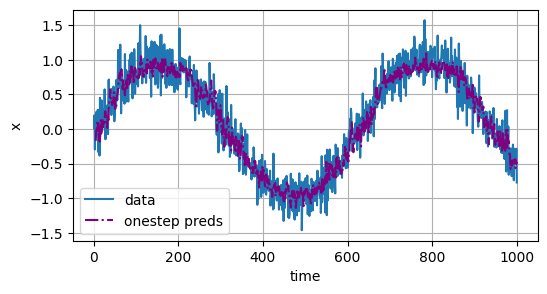

In [77]:
onestep_preds = net(features)

fig, ax = plt.subplots(figsize=(6, 3))
ax.grid(True)
ax.set_xlabel('time')
ax.set_ylabel('x')
ax.plot(time, x, label='data')
ax.plot(time[tau:], onestep_preds.detach().numpy(), label='onestep preds', c='purple', linestyle='-.')
plt.legend()
plt.show()

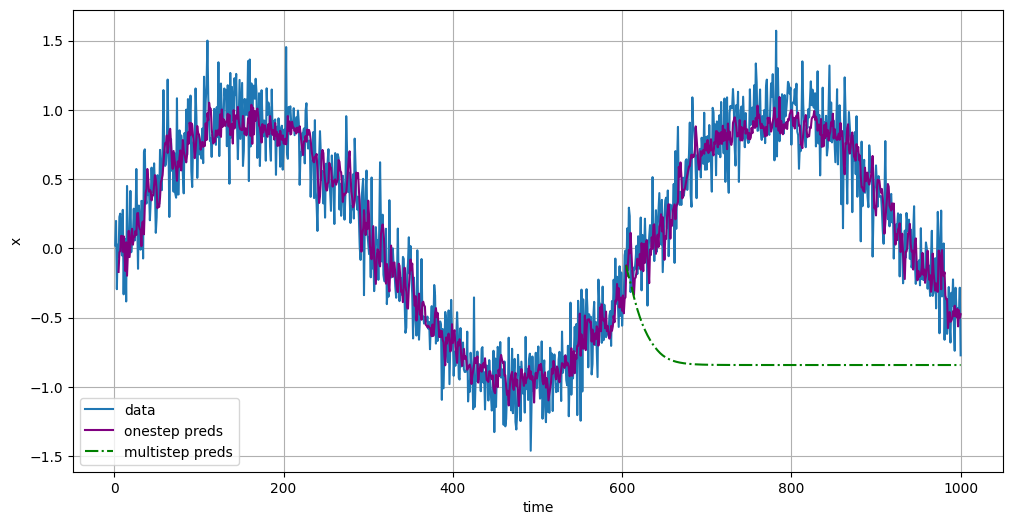

In [78]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

fig, ax = plt.subplots(figsize=(12, 6))
ax.grid(True)
ax.set_xlabel('time')
ax.set_ylabel('x')
ax.plot(time, x, label='data')
ax.plot(time[tau:], onestep_preds.detach().numpy(), label='onestep preds', c='purple')
ax.plot(time[n_train + tau:], multistep_preds[n_train + tau:].detach().numpy(), label='multistep preds', c='g', linestyle='-.')
plt.legend()
plt.show()


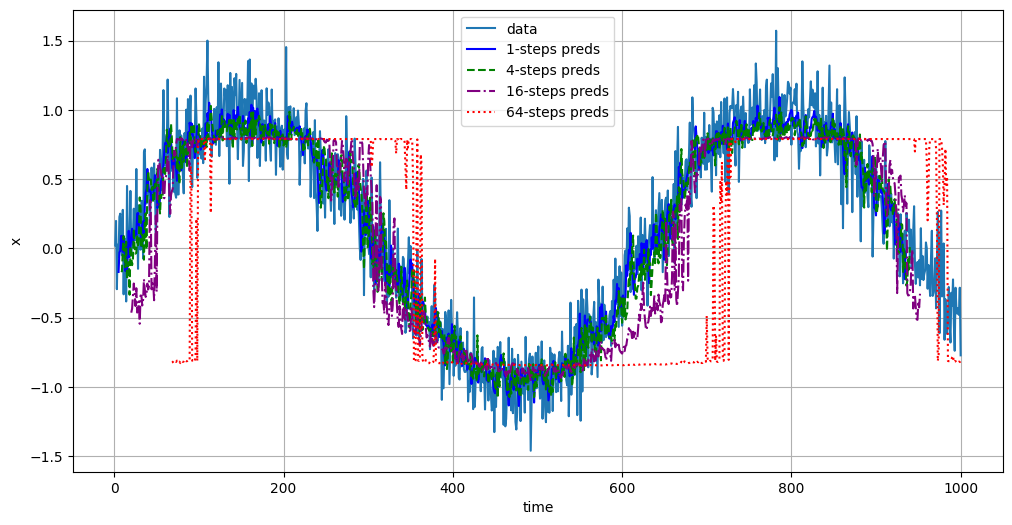

In [79]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
colors = ('b', 'g', 'purple', 'r')
linestyles = ('-', '--', '-.', ':')
fig, ax = plt.subplots(figsize=(12, 6))
ax.grid(True)
ax.set_xlabel('time')
ax.set_ylabel('x')
ax.plot(time, x, label='data')
for step, c, linestyle in zip(steps, colors, linestyles):
    ax.plot(time[tau + step - 1:T - max_steps + step], features[:, tau + step - 1].detach().numpy(), label=f'{step:d}-steps preds', c=c, linestyle=linestyle)
plt.legend()
plt.show()